In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sreehar","key":"21cf35b91f53c122ef3b6578c794773e"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json


!kaggle competitions download -c asap-aes


kaggle.json
  0% 0.00/1.79M [00:00<?, ?B/s]
100% 1.79M/1.79M [00:00<00:00, 59.9MB/s]
  0% 0.00/5.49M [00:00<?, ?B/s]
100% 5.49M/5.49M [00:00<00:00, 50.6MB/s]
  0% 0.00/214k [00:00<?, ?B/s]
100% 214k/214k [00:00<00:00, 70.2MB/s]
 76% 42.0M/55.0M [00:01<00:00, 35.1MB/s]
100% 55.0M/55.0M [00:01<00:00, 47.4MB/s]
  0% 0.00/14.9k [00:00<?, ?B/s]
100% 14.9k/14.9k [00:00<00:00, 18.5MB/s]
  0% 0.00/1.60M [00:00<?, ?B/s]
100% 1.60M/1.60M [00:00<00:00, 99.0MB/s]
  0% 0.00/14.9k [00:00<?, ?B/s]
100% 14.9k/14.9k [00:00<00:00, 13.0MB/s]
  0% 0.00/1.60M [00:00<?, ?B/s]
100% 1.60M/1.60M [00:00<00:00, 109MB/s]
  0% 0.00/41.4k [00:00<?, ?B/s]
100% 41.4k/41.4k [00:00<00:00, 43.2MB/s]
100% 4.86M/4.86M [00:00<00:00, 34.9MB/s]

  0% 0.00/6.20M [00:00<?, ?B/s]
100% 6.20M/6.20M [00:00<00:00, 55.9MB/s]
  0% 0.00/88.5k [00:00<?, ?B/s]
100% 88.5k/88.5k [00:00<00:00, 90.4MB/s]
  0% 0.00/2.01M [00:00<?, ?B/s]
100% 2.01M/2.01M [00:00<00:00, 137MB/s]
unzip:  cannot find or open asap-aes.zip, asap-aes.zip.zip or asap

In [ ]:
!unzip /content/training_set_rel3.tsv.zip

Archive:  /content/training_set_rel3.tsv.zip
  inflating: training_set_rel3.tsv   


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from functools import reduce
from operator import iconcat
import re
import spacy
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
tqdm.pandas()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Vocab:
    def __init__(self, min_frequency, vocab_size):
        self.min_frequency = min_frequency
        self.vocab_size = vocab_size

    def build_vocab(self, df, field):
        df_freq = self.get_token_frequency(df, field)
        df_freq = df_freq.loc[df_freq["frequency"] >= self.min_frequency]
        df_freq = df_freq.head(self.vocab_size-1)
        self.counts = dict(zip(df_freq["token"], df_freq["frequency"]))
        df_freq["index"] = np.arange(0, df_freq.shape[0], 1)+1
        self.stoi = dict(zip(df_freq["token"], df_freq["index"]))
        self.itos = dict(zip(df_freq["index"], df_freq["token"]))

    def get_token_frequency(self, df, field):
        corpus = df[field].values.tolist()
        flattened_tokens = reduce(iconcat, corpus, [])
        vocab, counts = np.unique(flattened_tokens, return_counts=True)
        df_token_freq = pd.DataFrame(zip(vocab, counts),
                                     columns=["token", "frequency"])
        df_token_freq.sort_values(by="frequency",
                                  ascending=False, inplace=True)
        return df_token_freq

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, dataset_path, min_frequency,
                 vocab_size):
        self.min_frequency = min_frequency
        self.df = pd.read_csv(dataset_path, delimiter = "\t", encoding="latin-1")
        self.nlp = spacy.load("en_core_web_sm",
                              disable=['ner', 'parser', 'tagger'])
        
        # Preprocess target and text

        self.df["essay_cleaned"] = self.df["essay"].\
            progress_apply(self.tokenizer)
        self.vocab_builder = Vocab(min_frequency=self.min_frequency,
                                   vocab_size=vocab_size)
        self.vocab_builder.build_vocab(self.df, "essay_cleaned")
        
        # Retain only those tokens in vocab
        self.df["essay_cleaned"] = \
            self.df["essay_cleaned"].progress_apply(lambda doc:
                                                     [token for token in doc
                                                      if token in self.vocab_builder.stoi.keys()])
        self.df["essay_token_idx"] = self.df["essay_cleaned"].progress_apply(lambda doc: 
                                                                               [self.vocab_builder.stoi[token] for token in doc] )
        self.df["len"] = self.df["essay_token_idx"].apply(len)
        
    def tokenizer(self, doc):
        doc = doc.lower()
        doc = self.nlp(doc)
        lemmas = [token.lemma_ for token in doc if not token.is_stop]
        lemmas = [lemma.strip() for lemma in lemmas if lemma != " "]
        return lemmas

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):

        reviews = np.array(self.df.iloc[idx]["essay_token_idx"])
        lengths = np.array(self.df.iloc[idx]["len"])
        scores = np.array(self.df.iloc[idx]["domain1_score"])

        return {"features" : reviews,
                "len" : lengths, 
                "target" : scores}

In [ ]:



from torch.optim import Adam

VOCAB_SIZE = 3000
vocab_builder = Vocab(min_frequency=50, vocab_size=VOCAB_SIZE)
ds = SentimentDataset(dataset_path="training_set_rel3.tsv", 
                      min_frequency=50, vocab_size=VOCAB_SIZE)
train_length = int(len(ds)*0.8)
test_length = len(ds) - train_length
train_ds, test_ds = random_split(ds, lengths = [train_length, test_length])

100%|██████████| 12976/12976 [00:00<00:00, 50710.73it/s]


In [ ]:
class EssayGrader(nn.Module):
    def __init__(self, embedding_dim, vocab_size, hidden_size):
        super(EssayGrader, self).__init__()
        self.emb = nn.Embedding(
                                num_embeddings=vocab_size,
                                embedding_dim=embedding_dim,
                                padding_idx=0)
        self.rnn = nn.LSTM(input_size = embedding_dim, 
                           hidden_size=hidden_size,
                           num_layers=1,
                           batch_first=True,
                           bidirectional=True)
        self.linear = nn.Linear(in_features=2*hidden_size,
                                out_features=128)
        self.linear2 = nn.Linear(in_features=128,
                                out_features=1)

    def forward(self, x_in):
        x, lengths = x_in
        embeddings = self.emb(x)
        packed_seq = pack_padded_sequence(embeddings,
                                          lengths, 
                                          batch_first=True, 
                                          enforce_sorted=False)
        outputs, (h_t, c_t) = self.rnn(packed_seq)
        hidden_states = torch.cat((h_t[-2, :, :], h_t[-1,:, :]), dim=1)
        hidden_states = nn.Dropout(p=0.4)(hidden_states)
        linear_out = self.linear(hidden_states)
        
        linear_out = self.linear2(linear_out)
        return linear_out

In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    y_pred = model(xb)
    loss = loss_func(y_pred, yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(y_pred)

from sklearn.metrics import r2_score
def get_metrics(model, xb, yb):
    y_pred = model(xb)
    score = r2_score(yb.detach().cpu().numpy(), y_pred.detach().cpu().numpy())
    return score, len(y_pred)


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_metrics_all, test_metrics_all = [], []
    train_loss_all, test_loss_all = [], []
    for epoch in range(epochs):
        
        model.train()
        losses, records = zip(*[loss_batch(model, loss_func, xb, yb, opt) for xb, yb in train_dl])
        train_loss = np.sum(np.multiply(losses, records)) / np.sum(records)
        
        model.eval()

        with torch.no_grad():
            losses, records = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
            train_scores, train_records = zip(*[get_metrics(model, xb, yb) for xb, yb in train_dl])
            test_scores, test_records = zip(*[get_metrics(model, xb, yb) for xb, yb in test_dl])
            
        test_loss = np.sum(np.multiply(losses, records)) / np.sum(records)    
        
        train_metrics = np.sum(np.multiply(train_scores, train_records)) / np.sum(train_records)
        test_metrics = np.sum(np.multiply(test_scores, test_records)) / np.sum(test_records)
        
        train_loss_all.append(train_loss)
        test_loss_all.append(test_loss)

        train_metrics_all.append(train_metrics)
        test_metrics_all.append(test_metrics)

        print(f"""EPOCH: {epoch}|TRAIN LOSS: {train_loss:.8f}|TRAIN R2: {train_metrics:.8f}|TEST LOSS: {test_loss:.8f}|TEST R2: {test_metrics:.8f}""")
        
    return {"train_r2" : train_metrics_all, "test_r2": test_metrics_all, 
            "loss" : train_loss_all, "test_loss" : test_loss_all}



def plot_results(history):
  %matplotlib inline
  import matplotlib.pyplot as plt
  fig = plt.figure(figsize = (16, 4))
  fig.add_subplot(121)
  epochs = len(history["loss"])
  plt.plot(np.arange(0, epochs), history["loss"])
  plt.plot(np.arange(0, epochs), history["test_loss"])
  plt.title("Loss")
  plt.legend(["train", "test"])
  plt.xticks(np.arange(0, epochs, 1))
  plt.xlabel("epoch")
  
  fig.add_subplot(122)
  plt.plot(np.arange(0, epochs), history["train_r2"])
  plt.plot(np.arange(0, epochs), history["test_r2"])
  plt.ylim(0,1)
  plt.title("Metrics - R2")
  plt.legend(["train", "test"])
  plt.xticks(np.arange(0, epochs, 1))
  plt.xlabel("epoch")
  plt.show()



In [ ]:
def collate_fn(batch):
  essays = [torch.tensor(x["features"]) for x in batch]
  lens = [torch.tensor(x["len"]) for x in batch]
  target = [torch.tensor(x["target"]) for x in batch]

  padded_essays = pad_sequence(essays, batch_first=True, padding_value=0)
  lens = torch.tensor(lens)
  target = torch.tensor(target).reshape(-1,1)
  return (padded_essays.long().to(device), lens.float().to(device)), target.float().to(device)

EPOCH: 0|TRAIN LOSS: 45.14521852|TRAIN R2: 0.72646993|TEST LOSS: 21.33814313|TEST R2: 0.72677593
EPOCH: 1|TRAIN LOSS: 18.79956290|TRAIN R2: 0.75081349|TEST LOSS: 18.94044071|TEST R2: 0.75398225
EPOCH: 2|TRAIN LOSS: 16.86258274|TRAIN R2: 0.83970515|TEST LOSS: 14.87129796|TEST R2: 0.80902639
EPOCH: 3|TRAIN LOSS: 10.44704426|TRAIN R2: 0.87200931|TEST LOSS: 12.63268554|TEST R2: 0.84405088
EPOCH: 4|TRAIN LOSS: 8.03275854|TRAIN R2: 0.90957328|TEST LOSS: 8.62607700|TEST R2: 0.88651411
EPOCH: 5|TRAIN LOSS: 6.44098952|TRAIN R2: 0.92657153|TEST LOSS: 7.60704149|TEST R2: 0.89778134
EPOCH: 6|TRAIN LOSS: 6.74138500|TRAIN R2: 0.92939383|TEST LOSS: 7.33958761|TEST R2: 0.90485275
EPOCH: 7|TRAIN LOSS: 5.92987213|TRAIN R2: 0.93873466|TEST LOSS: 6.38555807|TEST R2: 0.91469270
EPOCH: 8|TRAIN LOSS: 4.87827952|TRAIN R2: 0.94251855|TEST LOSS: 6.00244789|TEST R2: 0.92235069
EPOCH: 9|TRAIN LOSS: 4.49893762|TRAIN R2: 0.94588694|TEST LOSS: 6.44947138|TEST R2: 0.92208231


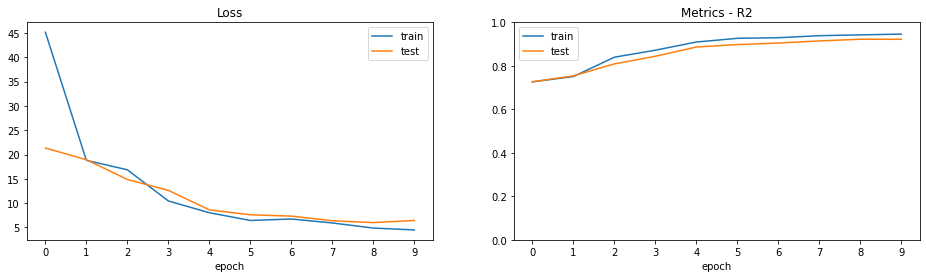

In [ ]:
def get_data(train_ds, test_ds, bs, vocab_size):
    train_dl = DataLoader(train_ds, batch_size = bs, shuffle=True, 
                collate_fn=collate_fn)
    test_dl = DataLoader(test_ds, batch_size = bs, shuffle=False,
                collate_fn=collate_fn)
    return train_dl, test_dl
train_dl, test_dl = get_data(train_ds, test_ds, bs=64, vocab_size=VOCAB_SIZE)
model = EssayGrader(embedding_dim=64, vocab_size=3000+1, hidden_size=128).to(device)

loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

history  = fit(epochs=10, model=model, loss_func=loss_fn, 
    opt=optimizer, train_dl=train_dl, valid_dl=test_dl)
plot_results(history=history)